# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Revised**: October 8, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/imputer/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTMF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Abstract

Large-scale and multidimensional spatiotemporal data sets are becoming ubiquitous in many real-world applications such as monitoring traffic and air quality. Making predictions on these time series has become a critical challenge due to not only the large-scale and high-dimensional nature but also the considerable amount of missing data. In this work, we propose a Bayesian Temporal Matrix Factorization (BTMF) model for modeling multidimensional time series - and in particular spatiotemporal data - in the presence of missing values. By integrating low-rank matrix factorization and vector autoregressive (VAR) process into a single probabilistic graphical model, our model can effectively perform predictions without imputing those missing values. We develop efficient Gibbs sampling algorithms for model inference and test BTMF on several real-world spatiotemporal data sets (i.e., a typical kind of multivariate time series data) for both missing data imputation and short-term rolling prediction tasks. This post is mainly about BTMF and its **`Python`** implementation with an application of spatiotemporal data imputation.

## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


## Model Description

Given a partially observed spatiotemporal matrix $Y\in\mathbb{R}^{N \times T}$, one can factorize it into a spatial factor matrix $W\in\mathbb{R}^{R \times N}$ and a temporal factor matrix $X\in\mathbb{R}^{R \times T}$ following general matrix factorization model:
\begin{equation}
Y\approx W^{\top}X,
\label{btmf_equation1}
\end{equation}
and element-wise, we have
\begin{equation}
y_{it}\approx \boldsymbol{w}_{i}^\top\boldsymbol{x}_{t}, \quad \forall (i,t),
\label{btmf_equation2}
\end{equation}
where vectors $\boldsymbol{w}_{i}$ and $\boldsymbol{x}_{t}$ refer to the $i$-th column of $W$ and the $t$-th column of $X$, respectively.

The standard matrix factorization model is a good approach to deal with the missing data problem; however, it cannot capture the dependencies among different columns in $X$, which are critical in modeling time series data. To better characterize the temporal dependencies and impose temporal smoothness, a novel AR regularizer is introduced on $X$ in TRMF (i.e., Temporal Regularizer Matrix Factorization proposed by [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)):
\begin{equation} \label{equ:VAR}
\begin{aligned}
    \boldsymbol{x}_{t+1}&=\sum\nolimits_{k=1}^{d}A_{k}\boldsymbol{x}_{t+1-h_k}+\boldsymbol{\epsilon}_t, \\
    &=A^\top \boldsymbol{v}_{t+1}+\boldsymbol{\epsilon}_{t}, \\
\end{aligned}
\end{equation}
where $\mathcal{L}=\left\{h_1,\ldots,h_k,\ldots,h_d\right\}$ is a lag set ($d$ is the order of this AR model), each $A_k$ ($k\in\left\{1,...,d\right\}$) is a $R\times R$ coefficient matrix, and $\boldsymbol{\epsilon}_t$ is a zero mean Gaussian noise vector. For brevity, matrix $A\in \mathbb{R}^{(R d) \times R}$ and vector $\boldsymbol{v}_{t+1}\in \mathbb{R}^{(R d) \times 1}$ are defined as
\begin{equation*}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} ,\quad \boldsymbol{v}_{t+1}=\left[\begin{array}{c}{\boldsymbol{x}_{t+1-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t+1-h_d}}\end{array}\right] .
\end{equation*}

<img src="../images/rolling_prediction.png" alt="drawing" width="400"/>

> **Figure 2**: A graphical illustration of the rolling prediction scheme using BTMF (with VAR process) (green: observed data; white: missing data; red: prediction).

In [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf), to avoid overfitting and reduce the number of parameters, the coefficient matrix in TRMF is further assumed to be a diagonal $A_k=\text{diag}(\boldsymbol{\theta}_{k})$. Therefore, they have
\begin{equation} \label{equ:AR}
\boldsymbol{x}_{t+1}=\boldsymbol{\theta}_{1}\circledast\boldsymbol{x}_{t+1-h_1}+\cdots+\boldsymbol{\theta}_{d}\circledast\boldsymbol{x}_{t+1-h_d}+\boldsymbol{\epsilon}_t,
\end{equation}
where the symbol $\circledast$ denotes the element-wise Hadamard product. However, unlike this individual autoregressive (AR) process, a vector autoregressive (VAR) process is actually more powerful for capturing multivariate time series patterns.

<img src="../images/rolling_prediction_strategy.png" alt="drawing" width="400"/>

> **Figure 3**: A graphical illustration of the rolling prediction scheme using BTMF (with AR process) (green: observed data; white: missing data; red: prediction).

## Bayesian Temporal Matrix Factorization Model

### 1 Model Specification

Following the general Bayesian probabilistic matrix factorization models (e.g., BPMF proposed by [Salakhutdinov & Mnih, 2008](https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf)), we assume that each observed entry in $Y$ follows a Gaussian distribution with precision $\tau$:
\begin{equation}
y_{i,t}\sim\mathcal{N}\left(\boldsymbol{w}_i^\top\boldsymbol{x}_t,\tau^{-1}\right),\quad \left(i,t\right)\in\Omega.
\label{btmf_equation3}
\end{equation}

On the spatial dimension, we use a simple Gaussian factor matrix without imposing any dependencies explicitly:
\begin{equation}
\boldsymbol{w}_i\sim\mathcal{N}\left(\boldsymbol{\mu}_{w},\Lambda_w^{-1}\right),
\end{equation}
and we place a conjugate Gaussian-Wishart prior on the mean vector and the precision matrix:
\begin{equation}
\boldsymbol{\mu}_w | \Lambda_w \sim\mathcal{N}\left(\boldsymbol{\mu}_0,(\beta_0\Lambda_w)^{-1}\right),\Lambda_w\sim\mathcal{W}\left(W_0,\nu_0\right),
\end{equation}
where $\boldsymbol{\mu}_0\in \mathbb{R}^{R}$ is a mean vector, $\mathcal{W}\left(W_0,\nu_0\right)$ is a Wishart distribution with a $R\times R$ scale matrix $W_0$ and $\nu_0$ degrees of freedom.

In modeling the temporal factor matrix $X$, we re-write the VAR process as:
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}
\mathcal{N}\left(\boldsymbol{0},I_R\right),&\text{if $t\in\left\{1,2,...,h_d\right\}$}, \\
\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),&\text{otherwise},\\
\end{cases}\\
\end{aligned}
\label{btmf_equation5}
\end{equation}

Since the mean vector is defined by VAR, we need to place the conjugate matrix normal inverse Wishart (MNIW) prior on the coefficient matrix $A$ and the covariance matrix $\Sigma$ as follows,
\begin{equation}
\begin{aligned}
A\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right),\quad
\Sigma \sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where the probability density function for the $Rd$-by-$R$ random matrix $A$ has the form:
\begin{equation}
\begin{aligned}
&p\left(A\mid M_0,\Psi_0,\Sigma\right) \\
=&\left(2\pi\right)^{-R^2d/2}\left|\Psi_0\right|^{-R/2}\left|\Sigma\right|^{-Rd/2} \\
&\times \exp\left(-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(A-M_0\right)^{\top}\Psi_{0}^{-1}\left(A-M_0\right)\right]\right), \\
\end{aligned}
\label{mnpdf}
\end{equation}
where $\Psi_0\in\mathbb{R}^{(Rd)\times (Rd)}$ and $\Sigma\in\mathbb{R}^{R\times R}$ are played as covariance matrices.

For the only remaining parameter $\tau$, we place a Gamma prior  $\tau\sim\text{Gamma}\left(\alpha,\beta\right)$ where $\alpha$ and $\beta$ are the shape and rate parameters, respectively. 

The above specifies the full generative process of BTMF, and we could also see the Bayesian graphical model shown in Figure 4. Several parameters are introduced to define the prior distributions for hyperparameters, including $\boldsymbol{\mu}_{0}$, $W_0$, $\nu_0$, $\beta_0$, $\alpha$, $\beta$, $M_0$, $\Psi_0$, and $S_0$. These parameters need to provided in advance when training the model. However, it should be noted that the specification of these parameters has little impact on the final results, as the training data will play a much more important role in defining the posteriors of the hyperparameters.

<img src="../images/btmf_net.png" alt="drawing" width="450"/>

> **Figure 4**: An overview graphical model of BTMF (time lag set: $\left\{1,2,...,d\right\}$). The shaded nodes ($y_{i,t}$) are the observed data in $\Omega$.


### 2 Model Inference

Given the complex structure of BTMF, it is intractable to write down the posterior distribution. Here we rely on the MCMC technique for Bayesian learning. In detail, we introduce a Gibbs sampling algorithm by deriving the full conditional distributions for all parameters and hyperparameters. Thanks to the use of conjugate priors in Figure 4, we can actually write down all the conditional distributions analytically. Below we summarize the Gibbs sampling procedure.  


#### 1) Sampling Factor Matrix $W$ and Its Hyperparameters



> For programming convenience, we use $W\in\mathbb{R}^{N\times R}$ to replace $W\in\mathbb{R}^{R\times N}$.

In [1]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [3]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau[i] * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau[i] * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

#### 2) Sampling VAR Coefficients $A$ and Its Hyperparameters

**Foundations of VAR**

Vector autoregression (VAR) is a multivariate extension of autoregression (AR). Formally, VAR for $R$-dimensional vectors $\boldsymbol{x}_{t}$ can be written as follows,
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&=A_{1} \boldsymbol{x}_{t-h_1}+\cdots+A_{d} \boldsymbol{x}_{t-h_d}+\boldsymbol{\epsilon}_{t}, \\
&= A^\top \boldsymbol{v}_{t}+\boldsymbol{\epsilon}_{t},~t=h_d+1, \ldots, T, \\
\end{aligned}
\end{equation}
where
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(R d) \times R},\quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{x}_{t-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right] \in \mathbb{R}^{(R d) \times 1}.
\end{equation}

In the following, if we define
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{x}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times R},\quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times(R d)},
\end{equation}
then, we could write the above mentioned VAR as
\begin{equation}
\underbrace{Z}_{(T-h_d)\times R}\approx \underbrace{Q}_{(T-h_d)\times (Rd)}\times \underbrace{A}_{(Rd)\times R}.
\end{equation}

> To include temporal factors $\boldsymbol{x}_{t},t=1,...,h_d$, we also define $$Z_0=\left[\begin{array}{c}{\boldsymbol{x}_{1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{h_d}^{\top}}\end{array}\right] \in \mathbb{R}^{h_d \times R}.$$



**Build a Bayesian VAR on temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I_R\right),~\text{otherwise}}.\end{cases}\\
A&\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right), \\
\Sigma &\sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where
\begin{equation}
\begin{aligned}
&\mathcal{M N}_{(R d) \times R}\left(A | M_{0}, \Psi_{0}, \Sigma\right)\\
\propto|&\Sigma|^{-R d / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[\Sigma^{-1}\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)\right]\right), \\
\end{aligned}
\end{equation}
and
\begin{equation}
\mathcal{I} \mathcal{W}\left(\Sigma | S_{0}, \nu_{0}\right) \propto|\Sigma|^{-\left(\nu_{0}+R+1\right) / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left(\Sigma^{-1}S_{0}\right)\right).
\end{equation}


**Likelihood from temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
&\mathcal{L}\left(X\mid A,\Sigma\right) \\
\propto &\prod_{t=1}^{h_d}p\left(\boldsymbol{x}_{t}\mid \Sigma\right)\times \prod_{t=h_d+1}^{T}p\left(\boldsymbol{x}_{t}\mid A,\Sigma\right) \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\sum_{t=h_d+1}^{T}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)^\top\Sigma^{-1}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)\right\} \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right)\right)\right]\right\}
\end{aligned}
\end{equation}


**Posterior distribution**

Consider
\begin{equation}
\begin{aligned}
&\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)+S_0+Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right) \\
=&A^\top\left(\Psi_0^{-1}+Q^\top Q\right)A-A^\top\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top A \\
&+\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&+M_0^\top\Psi_0^{-1}M_0+S_0+Z_0^\top Z_0+Z^\top Z \\
=&\left(A-M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}\left(A-M^{*}\right)+S^{*}, \\
\end{aligned}
\end{equation}
which is in the form of $\mathcal{MN}\left(\cdot\right)$ and $\mathcal{IW}\left(\cdot\right)$.

The $Rd$-by-$R$ matrix $A$ has a matrix normal distribution, and $R$-by-$R$ covariance matrix $\Sigma$ has an inverse Wishart distribution, that is,
\begin{equation}
A \sim \mathcal{M N}_{(R d) \times R}\left(M^{*}, \Psi^{*}, \Sigma\right), \quad \Sigma \sim \mathcal{I} \mathcal{W}\left(S^{*}, \nu^{*}\right),
\end{equation}
with
\begin{equation}
\begin{cases}
{\Psi^{*}=\left(\Psi_{0}^{-1}+Q^{\top} Q\right)^{-1}}, \\ {M^{*}=\Psi^{*}\left(\Psi_{0}^{-1} M_{0}+Q^{\top} Z\right)}, \\ {S^{*}=S_{0}+Z^\top Z+M_0^\top\Psi_0^{-1}M_0-\left(M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}M^{*}}, \\ 
{\nu^{*}=\nu_{0}+T-h_d}.
\end{cases}
\end{equation}

In [4]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

#### 3) Sampling Factor Matrix $X$

**Posterior distribution**
\begin{equation}
\begin{aligned}
y_{it}&\sim\mathcal{N}\left(\boldsymbol{w}_{i}^\top\boldsymbol{x}_{t},\tau^{-1}\right),~\left(i,t\right)\in\Omega, \\
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(\sum_{k=1}^{d}A_{k} \boldsymbol{x}_{t-h_k},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I\right),~\text{otherwise}}.\end{cases}\\
\end{aligned}
\end{equation}

If $t\in\left\{1,...,h_d\right\}$, parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+I\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}\right). \\
\end{aligned}
\end{equation}

If $t\in\left\{h_d+1,...,T\right\}$, then parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+\Sigma^{-1}\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}+\Sigma^{-1}\sum_{k=1}^{d}A_{k}\boldsymbol{x}_{t-h_k}\right), \\
\end{aligned}
\end{equation}
where
$$\boldsymbol{\psi}_{t+h_k}=\boldsymbol{x}_{t+h_k}-\sum_{l=1,l\neq k}^{d}A_{l}\boldsymbol{x}_{t+h_k-h_l}.$$



In [5]:
def sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

#### 4) Sampling Precision $\tau$

In [6]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

def sample_precision_scalar_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

In [7]:
def compute_mae(var, var_hat):
    return np.mean(np.abs(var - var_hat))

def compute_rmse(var, var_hat):
    return  np.sqrt(np.mean((var - var_hat) ** 2))

#### 5) BTMF Implementation



In [8]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, option = "factor", pos_miss = None):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    # if np.isnan(sparse_mat).any() == False:
    #     ind = sparse_mat != 0
    #     pos_obs = np.where(ind)
    #     pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    # elif np.isnan(sparse_mat).any() == True:
    #     pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
    #     ind = ~np.isnan(sparse_mat)
    #     pos_obs = np.where(ind)
    #     sparse_mat[np.isnan(sparse_mat)] = 0
    pos_test = pos_miss
    ind = ~pos_miss
    pos_obs = np.where(ind)
    num_obs = len(pos_obs[0])
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    A_plus = np.zeros((rank * d, rank))
    #temp_hat = np.zeros(len(pos_test[0]))
    temp_hat = np.zeros(len(sparse_mat[pos_test]))
    show_iter = 200
    mat_hat_plus = np.zeros((dim1, dim2))
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau[:, None] * ind
        tau_sparse_mat = tau[:, None] * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        if option == "factor":
            tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        elif option == "pca":
            tau = sample_precision_scalar_tau(sparse_mat, mat_hat, ind)
            tau = tau * np.ones(dim1)
        temp_hat += mat_hat[pos_test] # ERROR
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mae(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            #temp_hat = np.zeros(len(pos_test[0]))
            temp_hat = np.zeros(len(mat_hat[pos_test]))
            print()
        if it + 1 > burn_iter:
            W_plus += W
            X_plus += X
            A_plus += A
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X = X_plus / gibbs_iter
    A = A_plus / gibbs_iter
    mae = compute_mae(dense_test, mat_hat[:, : dim2][pos_test])
    rmse = compute_rmse(dense_test, mat_hat[:, : dim2][pos_test])

    print('Imputation MAPE: {:.6}'.format(mae))
    print('Imputation RMSE: {:.6}'.format(rmse))
    print()
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat[:, : dim2][pos_test], W, X, A, mae, rmse

## Arrival

In [77]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def read_raw_data(name):
    data = pd.read_csv(name, index_col=0, parse_dates=True)
    columns_name = list(data.columns)
    index = data.index
    ##minmax-score
    norlizer = MinMaxScaler().fit(data)
    data = norlizer.transform(data)
    return data, columns_name, index, norlizer

def evaluate(raw_data, prediction, mask=None, seasonal=None):
    #rmse = RMSE_Metric(raw_data, miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), prediction), axis=0), missing_flag=missing_flag)
    #print('RMSE:', rmse)
    prediction = prediction[mask].flatten()
    missed_raw_data = raw_data[mask].flatten()
    if seasonal is not None:
        missed_seasonal = seasonal[mask].flatten()
        concated_prediction += missed_seasonal
        missed_raw_data += missed_seasonal

    rmse = np.sqrt(mean_squared_error(missed_raw_data, prediction))
    mae = mean_absolute_error(missed_raw_data, prediction)
    #mape = mean_absolute_percentage_error(missed_raw_data, concated_prediction)
    #print('RMSE2:', rmse2)
    return (rmse, mae), prediction#, mape

import time
import numpy as np
import scipy.io
from pathlib import Path
np.random.seed(1000)

test_len = 12
log_dir = Path('../logs/eval_BTMF_univariate_0901/')
root_dir = Path('../..')
(root_dir/log_dir).mkdir(exist_ok=True)

datasets = {
    'AU': '../data/open-data/HK2012-2018/Australia.csv',
    'PH': '../data/open-data/HK2012-2018/Philippine.csv',
    'SG': '../data/open-data/HK2012-2018/Singapore.csv',
    'TH': '../data/open-data/HK2012-2018/Thailand.csv',
    'UK': '../data/open-data/HK2012-2018/United_Kingdom.csv',
    'US': '../data/open-data/HK2012-2018/United_States.csv',
   # 'competition': '../data/competition-data/forecasting_dataset_extend.csv',
}
masks = {
    'random6m': '../data/masks/random6m.npy',
    'random12m': '../data/masks/random12m.npy',
    'block6m': '../data/masks/block6m.npy',
    'block12m': '../data/masks/block12m.npy',
    'random24m': '../data/masks/random24m.npy',
    'block24m': '../data/masks/block24m.npy'
}

In [78]:
from itertools import product
from pathlib import Path
import pandas as pd
if (root_dir/log_dir/'result.csv').exists():
    df_result = pd.read_csv(root_dir/log_dir/'result.csv', index_col=['dataset', 'mask', 'stl', 'method'])
else:
    df_result = pd.DataFrame(columns=['dataset', 'mask', 'stl', 'method', 'rmse', 'mae'])
    df_result.set_index(['dataset', 'mask', 'stl', 'method'], inplace=True)
    for mask_name in masks.keys():
        df_result.loc[('competition', mask_name, False, 'BTMF')] = (100, 100)

In [22]:
from itertools import product
from pathlib import Path
import pandas as pd
#df_result = pd.read_csv(root_dir/log_dir/'result.csv')

rank = 10
burn_iter = 400
gibbs_iter = 200

with open(root_dir/log_dir/'result.csv', "w") as f:
    f.write("dataset,mask,stl,method,rmse,mae\n")

for rank, burn_iter, gibbs_iter in product([5, 10], [100, 200, 400], [50, 100, 200]):
    for dataset, mask_name, stl, method in product(datasets.keys(),masks.keys(), [False], ['BTMF']):
        data, columns_name, index, norlizer = read_raw_data(root_dir/datasets[dataset])
        mask = np.load(root_dir/masks[mask_name]).astype(bool)
    
        # data = data[:-test_len, 0:1]
        #data = data[:, 0:1]
        #mask = mask.reshape(-1,1)
    
        miss_data = data.copy()
        miss_data[mask] = 0
        #train_miss_data = miss_data[:-test_len].T
        #eval_real_data = data[:-test_len].T
        train_miss_data = miss_data.T
        eval_real_data = data.T
        
        dim1, dim2 = train_miss_data.shape
        init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
        time_lags = np.array([1,2, 12])
    
        prediction, W, X, A, mae, rmse = BTMF(eval_real_data, train_miss_data, init, rank, time_lags, burn_iter, gibbs_iter, pos_miss=mask.T)
        # print(mae, rmse)
        # (rmse, mae), prediction = evaluate(data[:-test_len], prediction, mask[:-test_len])
        old_result = df_result.loc[(dataset, mask_name, False, 'BTMF')]
        if old_result['rmse'] > rmse and old_result['mae'] > mae:
            result_str = f"{dataset}, {mask_name}, {stl}, {method}, {rmse}, {mae}\n"
            print(result_str)
            df_result.loc[(dataset, mask_name, False, 'BTMF')] = [rmse, mae]
            # with open(root_dir/log_dir/'result.csv', "a") as f:
            #     f.write(result_str)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_pred.npy", prediction)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_W.npy", W)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_X.npy", X)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_A.npy", A)

df_result.to_csv(root_dir/log_dir/'result.csv')

Imputation MAPE: 0.0403576
Imputation RMSE: 0.0592754

competition, random6m, False, BTMF, 0.059275449526479465, 0.040357624398014796

Imputation MAPE: 0.0374733
Imputation RMSE: 0.05458

competition, random12m, False, BTMF, 0.05458004858438166, 0.037473268461853455

Imputation MAPE: 0.0568177
Imputation RMSE: 0.0843855

competition, random18m, False, BTMF, 0.08438551167773645, 0.05681765422417778

Imputation MAPE: 0.0390304
Imputation RMSE: 0.0685433

Imputation MAPE: 0.044314
Imputation RMSE: 0.072499

Imputation MAPE: 0.0515727
Imputation RMSE: 0.0802797

competition, random18m, False, BTMF, 0.08027968353815089, 0.051572702919535425

Imputation MAPE: 0.0417778
Imputation RMSE: 0.0626788

Imputation MAPE: 0.0399173
Imputation RMSE: 0.0589894

Imputation MAPE: 0.0374266
Imputation RMSE: 0.0547184

competition, random18m, False, BTMF, 0.05471841083349417, 0.03742657239740804

Iter: 200
MAPE: 0.0366005
RMSE: 0.0719504

Imputation MAPE: 0.036265
Imputation RMSE: 0.0713637

Iter: 200
MAPE

### Arrival EDA

In [189]:
dataset_name = 'AU'
mask_name = 'random12m'

W = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_W.npy")
A = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_A.npy")
X = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_X.npy")
pred = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_pred.npy")

In [190]:
for arr in [W, A, X, pred]:
    print(arr.shape)

(1, 5)
(15, 5)
(72, 5)
(12,)


In [191]:
from scipy.spatial import distance as dist
dist_mat = dist.cdist(X, X, metric='euclidean')

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data, columns_name, time_idx, scaler = read_raw_data(root_dir/datasets[dataset_name])
mask = np.load(root_dir/masks[mask_name]).astype(bool)
data = data[:-12,0]
time_idx = time_idx[:-12]

Text(0.5, 1.0, 'dataset: AU, mask: random12m')

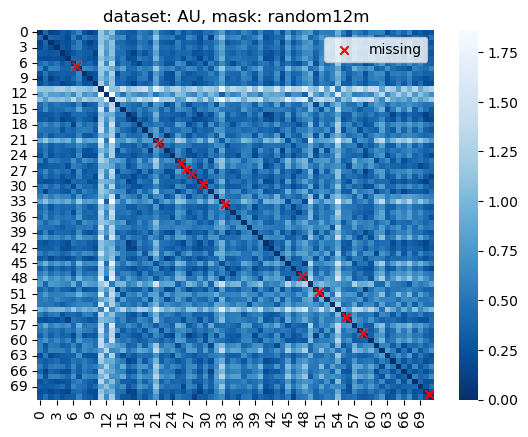

In [193]:
sns.heatmap(dist_mat, cmap='Blues_r')
mask_idx = np.argwhere(mask)
plt.scatter(mask_idx,mask_idx, marker='x', c='red', label='missing')
plt.legend()
plt.title(f'dataset: {dataset_name}, mask: {mask_name}')

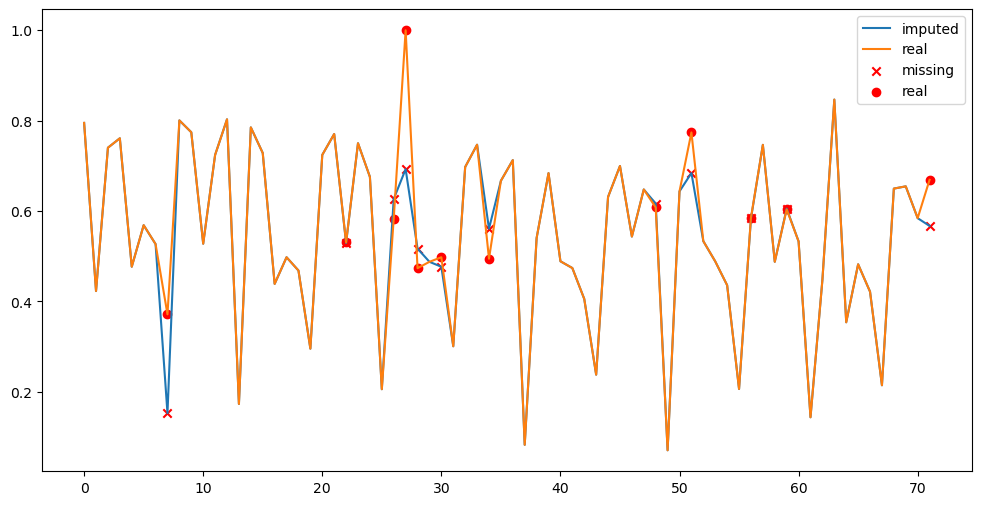

In [194]:
plt.figure(figsize=(12,6))

imputed = data.copy()
imputed[mask] = pred
mask_idx = np.argwhere(mask)
plt.plot(imputed, label='imputed')
plt.plot(data, label='real')
plt.scatter(mask_idx, imputed[mask_idx], marker='x', c='red', label='missing')
plt.scatter(mask_idx, data[mask_idx], marker='o', c='red', label='real')
plt.legend()

In [238]:
# AU random12 1 7 9 3
# AU block12  
check_idx = 2

most_similar_idx = np.argsort(dist_mat[mask_idx[check_idx]]).ravel()
most_similar_idx[1:6]

array([69, 41, 56,  5, 29])

In [239]:
time_idx[[0,1,2]].strftime('%Y-%m')

Index(['2012-01', '2012-02', '2012-03'], dtype='object', name='date')

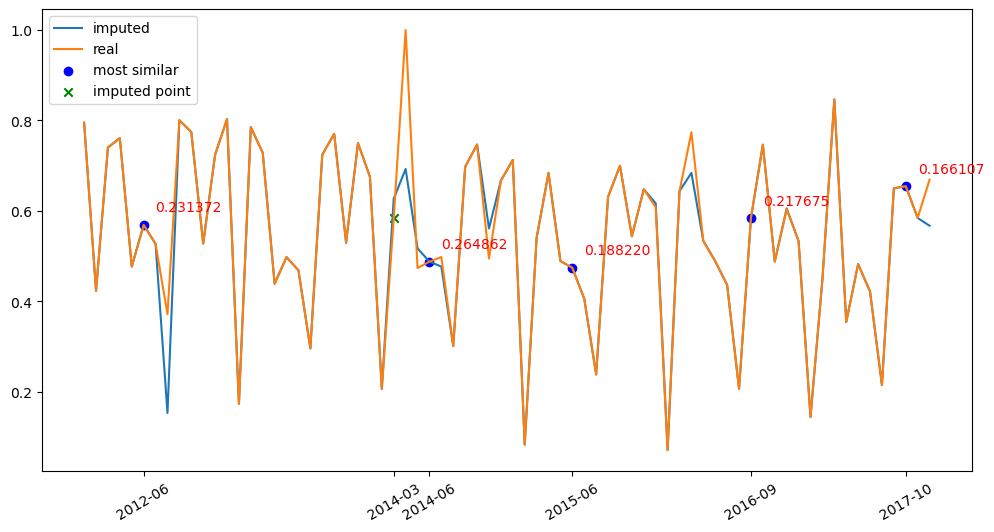

In [240]:
plt.figure(figsize=(12,6))

imputed = data.copy()
imputed[mask] = pred
mask_idx = np.argwhere(mask).flatten()
plt.plot(imputed, label='imputed')
plt.plot(data, label='real')
plt.scatter(most_similar_idx[1:6], imputed[most_similar_idx[1:6]], marker='o', c='blue', label='most similar')
plt.scatter(mask_idx[check_idx], data[mask_idx[check_idx]], marker='x', c='green', label='imputed point')

ticks = sorted(list(most_similar_idx[:6]))
plt.xticks(ticks, time_idx[ticks].strftime('%Y-%m'), rotation=30)
for idx in most_similar_idx[1:6]:
    plt.text(idx+1, imputed[idx]+0.03, f'{dist_mat[mask_idx[check_idx]][idx]:2f}', fontsize=10, c='red')
plt.legend()

In [183]:
most_similar_idx[:6]

array([22, 58, 46, 34, 71, 19])

## Competition Data

In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def evaluate(raw_data, prediction, mask=None, seasonal=None):
    prediction = prediction[mask].flatten()
    missed_raw_data = raw_data[mask].flatten()
    if seasonal is not None:
        missed_seasonal = seasonal[mask].flatten()
        concated_prediction += missed_seasonal
        missed_raw_data += missed_seasonal

    rmse = np.sqrt(mean_squared_error(missed_raw_data, prediction))
    mae = mean_absolute_error(missed_raw_data, prediction)
    return (rmse, mae), prediction

import time
import numpy as np
import scipy.io
from pathlib import Path
np.random.seed(1000)

test_len = 12
log_dir = Path('../logs/eval_BTMF_competition_0925/')
root_dir = Path('../..')
(root_dir/log_dir).mkdir(exist_ok=True)

datasets = {
    'competition': '../data/competition-data/forecasting_dataset_extend.csv',
}
masks = {
    'random6m':  '../data/masks/competition_random6m.npy',
    'random12m': '../data/masks/competition_random12m.npy',
    'random18m': '../data/masks/competition_random18m.npy'    
}
def read_dataset(dataset_path):
    columns = [
        'Hong Kong SAR',
        'Macao',
        'Japan',
        'Korea',
        #'Maldives',
        #'Indonesia',
        'Singapore',
        'Thailand',
        #'Philippines',
        #'Cambodia',
        'USA',
        'Canada',
        'Australia'
    ]
    dfraw = pd.read_csv(dataset_path, parse_dates=[0],date_parser=lambda col: pd.to_datetime(col, format='%YM%m'))
    dfraw.set_index('Date', inplace=True)
    dfraw = dfraw[columns]
    df_norm = pd.DataFrame(
        index=dfraw.index,
        columns=dfraw.columns,
        data=MinMaxScaler().fit_transform(dfraw.fillna(0))
    )
    query_str = "Date>'2015-05-01' and Date<'2023-06-01'"

    df_clip = df_norm.query(query_str)
    return df_clip.values, list(df_clip.columns)
from itertools import product
from pathlib import Path
import pandas as pd
if (root_dir/log_dir/'result.csv').exists():
    df_result = pd.read_csv(root_dir/log_dir/'result.csv', index_col=['dataset', 'mask', 'stl', 'method'])
else:
    df_result = pd.DataFrame(columns=['dataset', 'mask', 'stl', 'method', 'rmse', 'mae'])
    df_result.set_index(['dataset', 'mask', 'stl', 'method'], inplace=True)
    for mask_name in masks.keys():
        df_result.loc[('competition', mask_name, False, 'BTMF')] = (100, 100)

In [ ]:
from itertools import product
from pathlib import Path
import pandas as pd
#df_result = pd.read_csv(root_dir/log_dir/'result.csv')

rank = 10
burn_iter = 400
gibbs_iter = 200

with open(root_dir/log_dir/'result.csv', "w") as f:
    f.write("dataset,mask,stl,method,rmse,mae\n")

for rank, burn_iter, gibbs_iter in product([5, 10], [100, 200, 400], [50, 100, 200]):
    for dataset, mask_name, stl, method in product(datasets.keys(),masks.keys(), [False], ['BTMF']):
        #data, columns_name, index, norlizer = read_raw_data(root_dir/datasets[dataset])
        data, columns_name = read_dataset(root_dir/datasets['competition'])
        mask = np.load(root_dir/masks[mask_name]).astype(bool)
    
        miss_data = data.copy()
        miss_data[mask] = 0

        train_miss_data = miss_data.T
        eval_real_data = data.T
        
        dim1, dim2 = train_miss_data.shape
        init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
        time_lags = np.array([1,2, 12])
    
        prediction, W, X, A, mae, rmse = BTMF(eval_real_data, train_miss_data, init, rank, time_lags, burn_iter, gibbs_iter, pos_miss=mask.T)

        old_result = df_result.loc[(dataset, mask_name, False, 'BTMF')]
        if old_result['rmse'] > rmse and old_result['mae'] > mae:
            result_str = f"{dataset}, {mask_name}, {stl}, {method}, {rmse}, {mae}\n"
            print(result_str)
            df_result.loc[(dataset, mask_name, False, 'BTMF')] = [rmse, mae]
            # with open(root_dir/log_dir/'result.csv', "a") as f:
            #     f.write(result_str)                                                                                                                               
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_pred.npy", prediction)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_W.npy", W)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_X.npy", X)
            np.save(root_dir/log_dir/f"{dataset}_{mask_name}_{method}_A.npy", A)

df_result.to_csv(root_dir/log_dir/'result.csv')

### Competition Data EDA

In [68]:
mask_name = 'random18m'
dataset_name = 'competition'
W = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_W.npy")
A = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_A.npy")
X = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_X.npy")
pred = np.load(root_dir/log_dir/f"{dataset_name}_{mask_name}_BTMF_pred.npy")

In [69]:
W.shape

(9, 10)

In [70]:
X.shape

(96, 10)

In [71]:
from scipy.spatial import distance as dist
dist_mat_X = dist.cdist(X, X, metric='euclidean')
dist_mat_W = dist.cdist(W, W, metric='euclidean')

<Axes: >

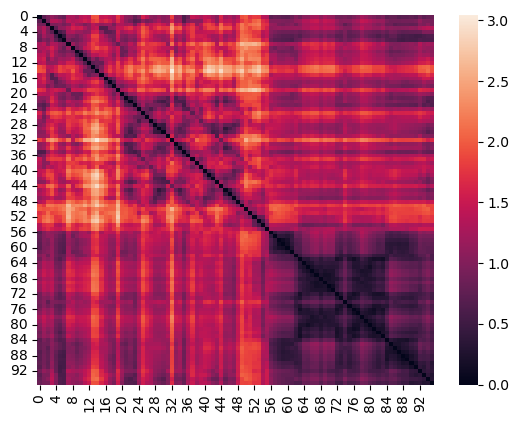

In [74]:
sns.heatmap(dist_mat_X)

<Axes: >

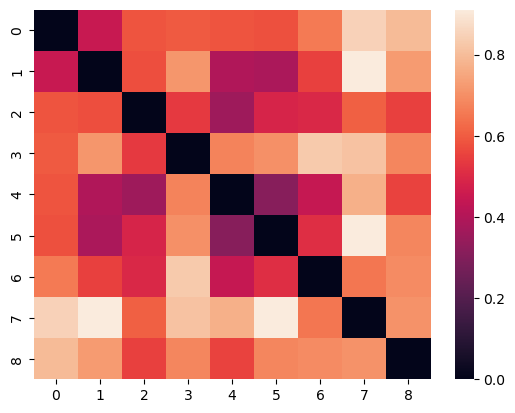

In [73]:
sns.heatmap(dist_mat_W)

## License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>